# Ramsey Model 

This code solves the Ramsey model by using Neural Network as functional approximator. It can be further extended to handle more complex dynamic programming model and in particular model with heterogeneous agent. 

The procedure is inspired by "Deep learning for solving dynamic economic models, Maliar et al. 2021" (https://www.sciencedirect.com/science/article/abs/pii/S0304393221000799). This is a slightly simpler example than the one showed in the paper. 

The notebook contains a detailed description of the model and the neural network architecture.

In [2]:
# Import section
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
import time

import numpy as np 
import matplotlib.pyplot as plt

from IPython.display import display, clear_output

In [3]:
"""Model Parameters: 
    - δ is the Depreciation Factor
    - β is the Discount Rate
    - γ is the parameter of CRRA Utility Function
    - α is the Capital Share in the Production Function""" 

δ = 1 
α = 0.36
β = 0.96
γ = 1

""" Ergodic Domain of the problem and Neural Network parameters """
kmin, kmax = 0.01, 0.5
act_fun = 'tanh'
N_HIDDEN = 128
BATCH_SIZE = 64

In [4]:
# Definition of the neural network, recall that we are trying to approximate the Value function, the policy
# And the lagrange multipliers as function of state. The state variables are k and a

# Here we define a structure for the neural network, then we istantiate each network
# for any function we want to approximate and then I create a function that takes 
# the input (the state variables) and spits out the function, so that it seems more natural later
# to write code
layers = [
    tf.keras.layers.Dense(N_HIDDEN, activation=act_fun, input_dim = 1),
    tf.keras.layers.Dense(N_HIDDEN, activation=act_fun),
    tf.keras.layers.Dense(N_HIDDEN, activation=act_fun),
    tf.keras.layers.Dense(1)
]

C_net = tf.keras.Sequential(layers)


def cf(k):
    # Scale the input 
    k = (k - kmin)/(kmax - kmin)*2.0 - 1.0
    
    x = tf.concat([k], axis=1)
    return tf.math.sigmoid(C_net(x))

In [5]:
# Utility functions and other useful pretty fantastic functions
def u(c):
    if γ != 1:
        return (c**(1-γ)-1)/(1-γ)
    else:
        return tf.math.log(c)

def d_u(c):
    return c**(-γ)

def d_uinv(a):
    return a**(-1/γ)
    
def f(k):
    return k**α

def d_f(k):
    return α*(k**(α-1))

def FB(a,b):
    return tf.sqrt(a**2 + b**2) - a - b 

def solution(k):
    return (1-α*β)*f(k)

def solution2(k):
    return (α*β)*f(k)

# Preliminary predicition plots

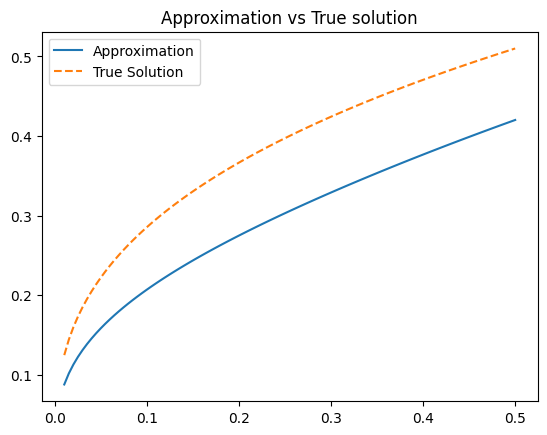

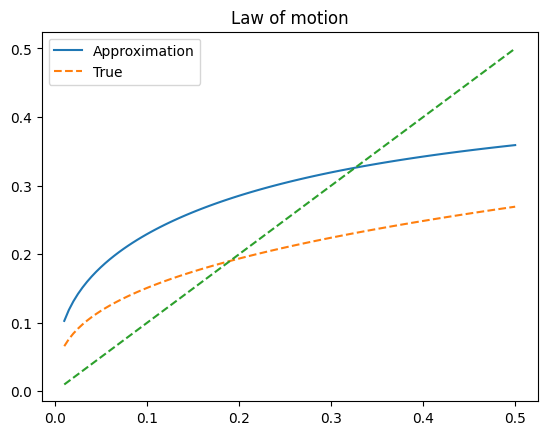

In [6]:
k = tf.constant(np.linspace(kmin,kmax,100,dtype=np.float32),shape=(100,1))

plt.figure()
plt.title('Approximation vs True solution')
share = cf(k)
c = share*(f(k) + (1-δ)*k)
plt.plot(k,c,label='Approximation')
plt.plot(k,solution(k),label='True Solution',linestyle='--')
plt.legend()
plt.show()

plt.figure()
plt.title('Law of motion')
kp = f(k) + (1-δ)*k - c
plt.plot(k,kp,label='Approximation')
plt.plot(k,solution2(k),linestyle='--',label='True')
plt.plot(k,k,linestyle='--')
plt.legend()
plt.show()

In [7]:
def loss_function(n):
    """ The loss function is composed of 3 main blocks:
        1) Sample of the economy today
        2) Transition of the economy tomorrow
        3) Definition of the loss function
        
        The function takes as input the batch_size and put as output several measures that will guide (hopefully)
        the neural network to a good solution"""
    
    # 1) Sample the economy today
    k = tf.random.uniform(shape=(n,1), minval= kmin, maxval= kmax)
    #k = tf.reshape(tf.linspace (kmin,kmax,BATCH_SIZE) ,shape=(BATCH_SIZE,1))

    
    # Evaluate the economy today
    share = cf(k)
    c = share*(f(k) + (1-δ)*k)
    
    # 2) Transition of the economy tomorrow
    k_p = f(k) + (1-δ)*k - c
    share_p = cf(k_p)
    c_p = share_p*(f(k_p) + (1-δ)*k_p)
    
    # Here we specify the FOCS, for the moment I will follow the approach of Villaverde
    # As specified in the slides, using the euler relative error
    h = (β*d_u(c_p)*(d_f(k_p) + (1-δ)))/d_u(c)
    minFB = FB(1 - share, 1 - h)

    
    # Loss functions
    FBerr = tf.reduce_mean(tf.square(minFB)) 
    
    return FBerr

In [8]:
thetaC = C_net.trainable_variables
optimizer = Adam(learning_rate=0.001)

In [9]:
@tf.function
def training_step():
    with tf.GradientTape(persistent=True) as tape:
        # Compute the loss function
        FBerr = loss_function(BATCH_SIZE)
        
    # Compute the gradient of the total loss function with respect to the network parameters    
    gradsC = tape.gradient(FBerr, thetaC)

    
    # Update parameters
    optimizer.apply_gradients(zip(gradsC, thetaC))

    
    return FBerr

In [10]:
def train(epochs):
    # To store the loss in order to plot
    total_losses = []
    
    # Take track of the starting time
    start = time.time()
    
    for i in range(0,epochs):
        clear_output(wait=True)
        FBerr  = training_step()
        
        # Append the loss function
        total_losses.append(FBerr.numpy())
        
        # Take track of the time
        now = time.time()
        
        print(f"""
        percentage: {round((i/epochs)*100,2)}%
        time elapsed: {now - start}
        epoch : {i+1}
        fb : {FBerr.numpy()}
        """)
    return total_losses

In [11]:
total_err = train(1000)


        percentage: 99.9%
        time elapsed: 2.300853729248047
        epoch : 1000
        fb : 6.879209649923723e-06
        


# Plots

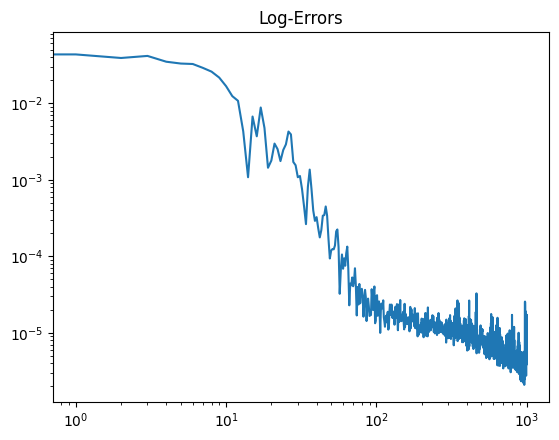

In [12]:
plt.figure()
plt.title('Log-Errors')
plt.xscale('log')
plt.yscale('log')
plt.plot(total_err)
plt.show()

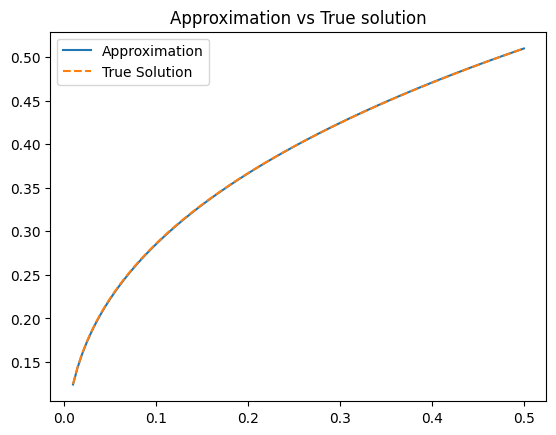

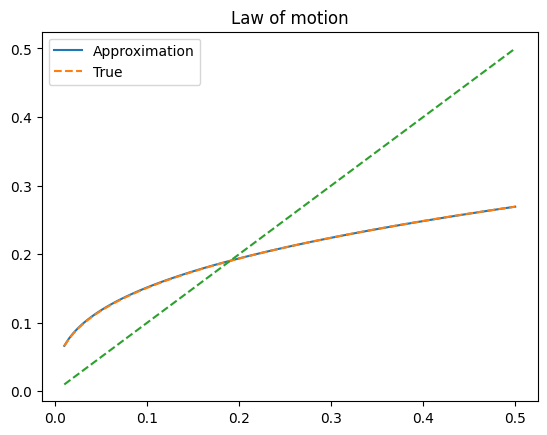

In [13]:
share = cf(k)
c = share*(f(k) + (1-δ)*k)
plt.figure()
plt.title('Approximation vs True solution')
plt.plot(k,c,label='Approximation')
plt.plot(k,solution(k),label='True Solution',linestyle='--')
plt.legend()
plt.show()

plt.figure()
plt.title('Law of motion')
kp = f(k) + (1-δ)*k - c
plt.plot(k,kp,label='Approximation')
plt.plot(k,solution2(k),linestyle='--',label='True')
plt.plot(k,k,linestyle='--')
plt.legend()
plt.show()